#  reV Losses Demo

NOTE: In all of these examples, the ``sam_file`` and ``res_file`` inputs point to files in
the reV test directory [`TESTDATADIR`](https://github.com/NREL/reV/tree/master/tests/data) that may not be copied in your install. You may want to download the relevant SAM system configs and resource data from that directory and point the ``sam_file`` and ``res_file`` variables to the correct filepath on your computer.

Shortcuts:  [Background](#bg) || [Power Curve Losses](#pc) || [Stochastically Scheduled Outage Losses](#st) 

<a id='bg'></a>
## Background

The simplest kinds of losses that can be applied for a reV generation run are haircut losses. Haircut losses simply reduce all power generated for each time step in the generation profile by a fixed percentage. For example, `15%` haircut losses can be applied by multiplying the output generation profile by a factor of `0.85`. These kinds of losses are perfectly acceptable if you are only interested in annual generation values. However, if you are performing analysis on a finer time-resolution, you will quickly notice that the generation profiles never reach maximum rated power (since all values have been scaled down). This is physically unrealistic and may lead to issues with some analyses (e.g. demand vs. generation on an hourly basis).

Most losses implemented in [SAM](https://sam.nrel.gov/) and [PySAM](https://pysam.readthedocs.io/en/latest/) as of this writing (4-29-2022) are haircut losses. To overcome this limitation, we implemented a `reV` losses module containing several utilities to supplement the use of haircut losses.

<a id='pc'></a>
## Power Curve Losses (Wind only)

Certain kinds of wind generation losses can be realized via a transformation of the turbine power curve. Typically, these transformations decrease the power generated at some or all of the power curve wind speeds. As a result, the generation of the wind turbine with a transformed power curve totals to an amount less than it would have had with the original power curve, thereby incurring losses. (Note that haircut losses can technically also be described as a power curve transformation - a simple percentage reduction of the power generation at all wind speeds)

In `reV`, you can specify a type of turbine transformation as well as a target loss percentage in order to apply these kinds of losses. See the documentation for more details about the different transformation options. 

Let's apply a very basic power curve transformation during a `reV` generation run. First, we will run generation without any losses to use as a baseline for comparison.

In [1]:
import os
import json
import tempfile

import numpy as np
import matplotlib.pyplot as plt

from reV import TESTDATADIR
from reV.config.project_points import ProjectPoints
from reV.generation.generation import Gen

lat_lons = np.array([[ 41.97, -71.78],
                     [ 41.05, -71.74],  
                     [ 41.25, -71.66]])

res_file = os.path.join(TESTDATADIR, 'wtk/ri_100_wtk_2012.h5')
sam_file = os.path.join(TESTDATADIR,
                            'SAM/wind_gen_standard_losses_0.json')

with open(sam_file, 'r', encoding='utf-8') as fh:
    sam_config = json.load(fh)
sam_config.pop('wind_farm_losses_percent', None);

In [2]:
with tempfile.TemporaryDirectory() as td:
    sam_fp = os.path.join(td, 'gen.json')
    with open(sam_fp, 'w+') as fh:
        fh.write(json.dumps(sam_config))

    pp = ProjectPoints.lat_lon_coords(lat_lons, res_file, sam_fp)
    gen_lossless = Gen.reV_run('windpower', pp, sam_fp, res_file,
                               max_workers=1, out_fpath=None,
                               output_request=(
                                   'cf_mean', 
                                   'cf_profile', 
                                   'gen_profile',
                                   'windspeed'
                                ))
display(gen_lossless.out['cf_mean'])

array([0.42881855, 0.6044542 , 0.5870515 ], dtype=float32)

<br>
Let's also run generation with only haircut losses for additional comparison.

In [3]:
TARGET_LOSS = 20  # large value for demo purposes

with tempfile.TemporaryDirectory() as td:
    sam_fp = os.path.join(td, 'gen.json')
    sam_config['turb_generic_loss'] = TARGET_LOSS
    with open(sam_fp, 'w+') as fh:
        fh.write(json.dumps(sam_config))

    pp = ProjectPoints.lat_lon_coords(lat_lons, res_file, sam_fp)
    gen_haircut = Gen.reV_run('windpower', pp, sam_fp, res_file,
                              max_workers=1, out_fpath=None,
                              output_request=(
                                  'cf_mean', 
                                  'cf_profile', 
                                  'gen_profile',
                                  'windspeed'
                               ))
display(gen_haircut.out['cf_mean'])

array([0.34305486, 0.48356336, 0.4696412 ], dtype=float32)

<br>
We can see that the capacity factors are all reduced by 20%, as expected.

In [4]:
gen_haircut.out['cf_mean'] / gen_lossless.out['cf_mean'] * 100

array([80.     , 79.99999, 80.     ], dtype=float32)

<br>
But, just as we would expect, the generation profiles never reach maximum rated power:

In [5]:
print("Profile reaches max rated power:", (gen_haircut.out['cf_profile'] == 1).any())
print("Max capacity factor:", gen_haircut.out['cf_profile'].max())

Profile reaches max rated power: False
Max capacity factor: 0.8


<br>
Now, instead of simple haircut losses, lets add some power curve losses. The transformation we are going to use is an exponential stretching. The losses in this type of transformation are distributed primarily across regions 2 and 3 of the power curve. In particular, losses are smaller for wind speeds closer to the cut-in speed, and larger for speeds close to rated power. 

In [6]:
power_curve_loss_info = {
    'target_losses_percent': TARGET_LOSS,  
    'transformation': 'exponential_stretching'

}
with tempfile.TemporaryDirectory() as td:
    sam_fp = os.path.join(td, 'gen.json')
    sam_config.pop('turb_generic_loss', None)
    sam_config['reV-power_curve_losses'] = power_curve_loss_info
    with open(sam_fp, 'w+') as fh:
        fh.write(json.dumps(sam_config))

    pp = ProjectPoints.lat_lon_coords(lat_lons, res_file, sam_fp)
    gen = Gen.reV_run('windpower', pp, sam_fp, res_file,
                      max_workers=1, out_fpath=None,
                      output_request=(
                          'cf_mean', 
                          'cf_profile', 
                          'gen_profile',
                          'windspeed'
                      ))
display(gen.out['cf_mean'])

array([0.34305367, 0.4835675 , 0.46964243], dtype=float32)

<br>
Note that the capacity factors are still reduced by approximately 20%:

In [7]:
gen.out['cf_mean'] / gen_lossless.out['cf_mean'] * 100

array([79.999725, 80.00068 , 80.00021 ], dtype=float32)

<br>
**HOWEVER**, the generation profile with the shifted power curve losses still reaches maximum rated power throughout the year. As we saw above, this is **not** possible with normal haircut losses.

In [8]:
print("Profile reaches max rated power:" ,(gen.out['cf_profile'] == 1).any())
print("Max capacity factor:", gen.out['cf_profile'].max())

Profile reaches max rated power: True
Max capacity factor: 1.0


<br>
We can visualize the effect of both kinds of losses in several ways.
<br>
<br>
First, let's look at a sample slice of the capacity factor profiles:

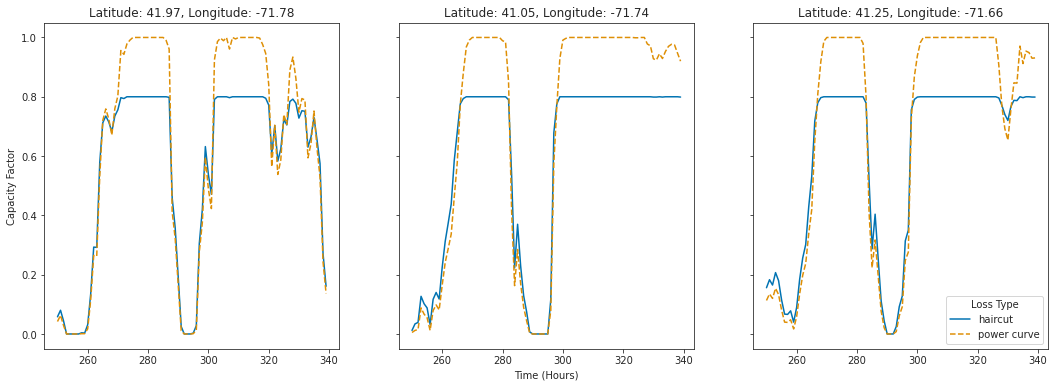

In [9]:
x_time = np.arange(250, 340)
fig, axes = plt.subplots(1, lat_lons.shape[0], figsize=(18, 6), sharey=True)
for ind, (ax, lat_lon) in enumerate(zip(axes, lat_lons)):
    ax.plot(
        x_time, gen_haircut.out['cf_profile'][x_time, ind], '-', 
        x_time, gen.out['cf_profile'][x_time, ind], '--'
    )
    ax.set_title('Latitude: {:0.2f}, Longitude: {:0.2f}'.format(*lat_lon))
    if ind == 0:
        ax.set_ylabel("Capacity Factor")
    elif ind == 1:
        ax.set_xlabel("Time (Hours)")

ax.legend(['haircut', 'power curve'], loc='best', title="Loss Type");

<br>
As you can see, the power curve loss profiles reach the max capacity factor (1), as expected, but show less generation at lower wind speeds.


Next, let's plot the generation as a function of wind speed. Note how the haircut losses simply scale down the turbine power curve.

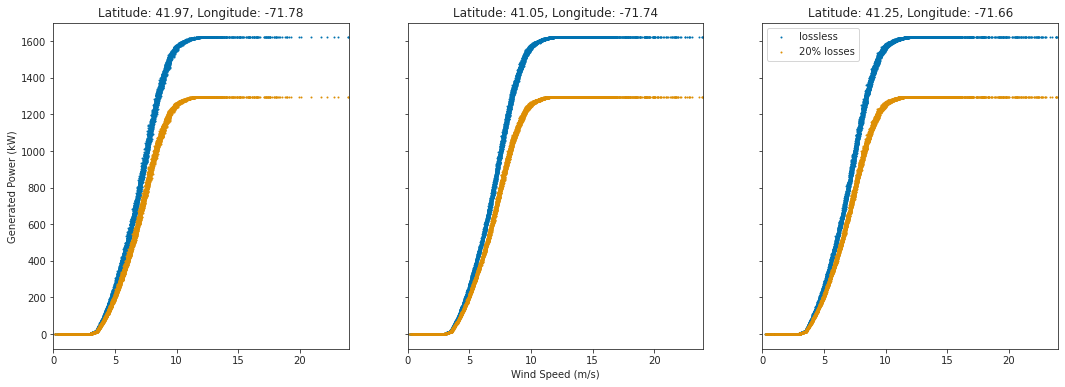

In [10]:
fig, axes = plt.subplots(1, lat_lons.shape[0], figsize=(18, 6), sharey=True)
for ind, (ax, lat_lon) in enumerate(zip(axes, lat_lons)):
    ax.scatter(
        gen_lossless.out['windspeed'][:, ind], 
        gen_lossless.out['gen_profile'][:, ind], 
        s=1, label='lossless'
    )
    ax.scatter(
        gen_haircut.out['windspeed'][:, ind], 
        gen_haircut.out['gen_profile'][:, ind], 
        s=1, label='{}% losses'.format(TARGET_LOSS)
    )
    ax.set_xlim(0, 24)
    ax.set_title('Latitude: {:0.2f}, Longitude: {:0.2f}'.format(*lat_lon))
    if ind == 0:
        ax.set_ylabel('Generated Power (kW)')
    elif ind == 1:
        ax.set_xlabel('Wind Speed (m/s)')

ax.legend();

<br>
On the other hand, power curve losses transform the curve itself, in this case using an exponential stretching.

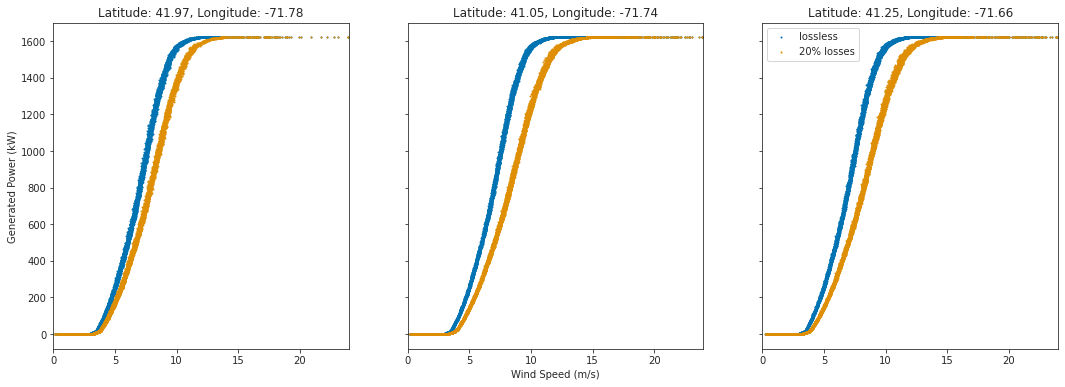

In [11]:
fig, axes = plt.subplots(1, lat_lons.shape[0], figsize=(18, 6), sharey=True)
for ind, (ax, lat_lon) in enumerate(zip(axes, lat_lons)):
    ax.scatter(
        gen_lossless.out['windspeed'][:, ind], 
        gen_lossless.out['gen_profile'][:, ind], 
        s=1, label='lossless'
    )
    ax.scatter(
        gen.out['windspeed'][:, ind], 
        gen.out['gen_profile'][:, ind], 
        s=1, label='{}% losses'.format(TARGET_LOSS)
    )
    ax.set_xlim(0, 24)
    ax.set_title('Latitude: {:0.2f}, Longitude: {:0.2f}'.format(*lat_lon))
    if ind == 0:
        ax.set_ylabel('Generated Power (kW)')
    elif ind == 1:
        ax.set_xlabel('Wind Speed (m/s)')

ax.legend();

<br>
Note that the transformation for the power curve to achieve the target losses is slightly different for each location. This is a result of the difference in the wind resource distribution between the sites.

We can also examine histograms and cumulative summation of the generation and wind speed distributions to help understand the emergence of power curve losses.

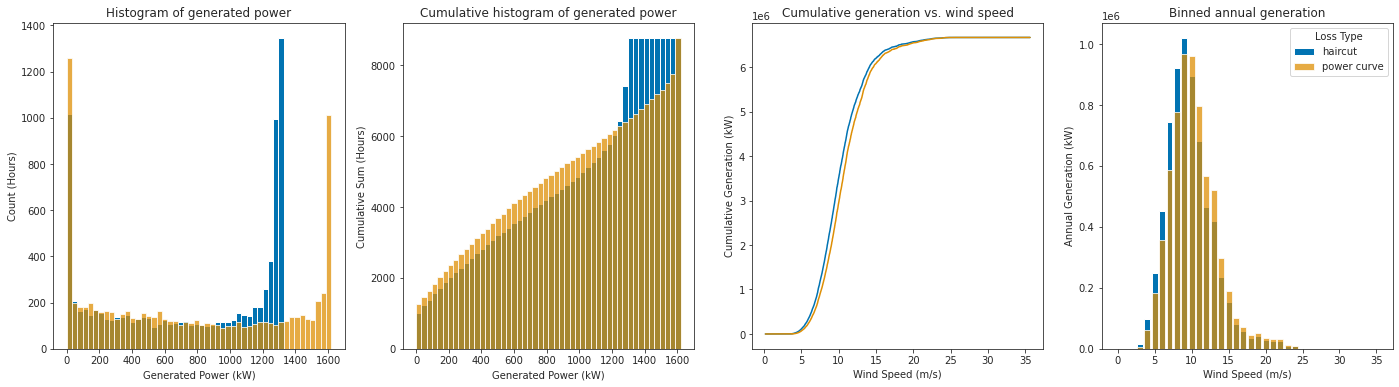

In [12]:
site_ind = 2
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
axes[0].hist(
    gen_haircut.out['gen_profile'][:, site_ind], 
    bins=50, 
    range=(0, 1620)
)
axes[0].hist(
    gen.out['gen_profile'][:, site_ind], 
    bins=50, 
    alpha=0.75, 
    range=(0, 1620)
)
axes[0].set_xlabel("Generated Power (kW)")
axes[0].set_ylabel("Count (Hours)")
axes[0].set_title("Histogram of generated power")

axes[1].hist(
    gen_haircut.out['gen_profile'][:, site_ind], 
    bins=50, 
    range=(0, 1620), 
    cumulative=True
)
axes[1].hist(
    gen.out['gen_profile'][:, site_ind], 
    bins=50, 
    alpha=0.75, 
    range=(0, 1620), 
    cumulative=True
)
axes[1].set_xlabel("Generated Power (kW)")
axes[1].set_ylabel("Cumulative Sum (Hours)")
axes[1].set_title("Cumulative histogram of generated power")

sorted_inds = np.argsort(gen.out['windspeed'][:, site_ind])
axes[2].plot(
    gen.out['windspeed'][sorted_inds, site_ind], 
    np.cumsum(gen_haircut.out['gen_profile'][sorted_inds, site_ind])
)
axes[2].plot(
    gen.out['windspeed'][sorted_inds, site_ind], 
    np.cumsum(gen.out['gen_profile'][sorted_inds, site_ind])
)
axes[2].set_xlabel("Wind Speed (m/s)")
axes[2].set_ylabel("Cumulative Generation (kW)")
axes[2].set_title("Cumulative generation vs. wind speed");


annual_powers_haircut = []
annual_powers_power_curve = []
for left_bin in range(36):
    mask = (
        (gen.out['windspeed'][:, site_ind] >= left_bin)
         & (gen.out['windspeed'][:, site_ind] < left_bin + 1)
    )
    annual_powers_haircut.append(
        gen_haircut.out['gen_profile'][mask, site_ind].sum()
    )
    annual_powers_power_curve.append(
        gen.out['gen_profile'][mask, site_ind].sum()
    )

axes[3].bar(range(36), annual_powers_haircut)
axes[3].bar(range(36), annual_powers_power_curve, alpha=0.75)
axes[3].set_xlabel("Wind Speed (m/s)")
axes[3].set_ylabel("Annual Generation (kW)")
axes[3].set_title("Binned annual generation");
axes[3].legend(['haircut', 'power curve'], loc='best', title="Loss Type");


<br>
If you use the simple horizontal power curve translation, please keep in mind that it is not physically realistic for most losses. You can see a listing of all the currently implemented power curve transformations by looking at the `TRANSFORMATIONS` dictionary.

In [13]:
from reV.losses.power_curve import TRANSFORMATIONS
display(TRANSFORMATIONS)

{'horizontal_translation': reV.losses.power_curve.HorizontalTranslation,
 'linear_stretching': reV.losses.power_curve.LinearStretching,
 'exponential_stretching': reV.losses.power_curve.ExponentialStretching}

In [14]:
transformation = TRANSFORMATIONS['horizontal_translation']
transformation?

Init signature: transformation(power_curve)
Docstring:     
Utility for applying horizontal power curve translations.

The mathematical representation of this transformation is:

.. math:: P_{transformed}(u) = P_{original}(u - t),

where :math:`P_{transformed}` is the transformed power curve,
:math:`P_{original}` is the original power curve, :math:`u` is
the wind speed, and :math:`t` is the transformation variable
(horizontal translation amount).

This kind of power curve transformation is simplistic, and should
only be used for a small handful of applicable turbine losses
(i.e. blade degradation). See ``Warnings`` for more details.

The losses in this type of transformation are distributed primarily
across region 2 of the power curve (the steep, almost linear,
portion where the generation rapidly increases):

.. image:: ../../../examples/rev_losses/horizontal_translation.png
   :align: center

Attributes
----------
power_curve : :obj:`PowerCurve`
    A :obj:`PowerCurve` object represe

Let's generate sample plots of these transformation to use for documentation purposes:

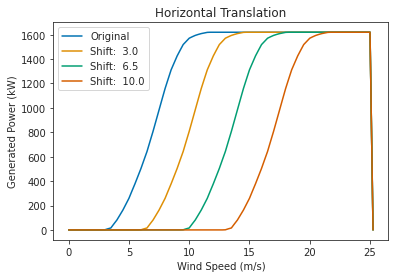

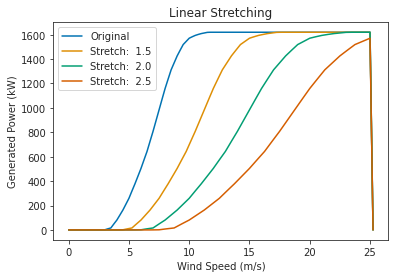

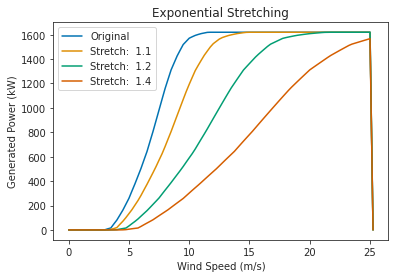

In [15]:
from reV.losses.power_curve import PowerCurve, TRANSFORMATIONS

sample_power_curve = PowerCurve(
    sam_config['wind_turbine_powercurve_windspeeds'],
    sam_config['wind_turbine_powercurve_powerout']
)

t_var_name_and_bounds = {
    'horizontal_translation': ['Shift', 3, 10],
    'linear_stretching': ['Stretch', 1.5, 2.5],
    'exponential_stretching': ['Stretch', 1.1, 1.4]
}

for t_name, t in TRANSFORMATIONS.items():
    _ = plt.plot(
        sample_power_curve.wind_speed, sample_power_curve, label='Original'
    )

    transformation = t(sample_power_curve)
    t_var_name, min_bound, max_bound = t_var_name_and_bounds[t_name]
    for scaler in np.linspace(min_bound, max_bound, 3):
        transformation = t(sample_power_curve)
        new_pc = transformation.apply(scaler)
        _ = plt.plot(
            new_pc.wind_speed, 
            new_pc, 
            label=f'{t_var_name}: {scaler: 0.1f}'
        )
    _ = plt.legend(loc='upper left')
    _ = plt.xlabel("Wind Speed (m/s)")
    _ = plt.ylabel("Generated Power (kW)")
    _ = plt.title(t_name.replace('_', ' ').title())
    _ = plt.savefig(f'{t_name}.png')
    _ = plt.show()

<br>
Note that all transformations respect the cutout speeds (i.e. 0 generation after cutout).
<br>
<br>
Implementing your own transformation is also easy! Simply subclass `PowerCurveTransformation` and implement the `apply` method and the `bounds` property. Run the cells below if you want more information about these requirements. 

In [19]:
from reV.losses.power_curve import PowerCurveTransformation
PowerCurveTransformation?

In [20]:
PowerCurveTransformation.apply?

In [21]:
PowerCurveTransformation.bounds?

<a id='st'></a>
## Stochastically Scheduled Outage Losses (Wind and Solar)

Another set of generation losses are the result of system maintenance on a wind or solar plant farm. Once again, it is perfectly fine to model these losses as haircut losses if you are only interested in annual energy production values, but you will run into the same issues discussed above if you are interested in a finer time resolution (namely, the generation never reaches maximum rated power).

With `reV`, you can apply a stochastic model for these kinds of losses. In particular, you can specify information about various types of outages that you would like to include in your generation profile. `reV` will then randomly schedule these outages, with different, but reproducible, outage profiles for each input site.

These types of losses can be applied for both wind and solar farms, but we will only consider win in this demo. Once again, we will start with a lossless generation run to use as a baseline for comparison.

In [16]:
import os
import json
import tempfile

import numpy as np
import matplotlib.pyplot as plt

from reV import TESTDATADIR
from reV.config.project_points import ProjectPoints
from reV.generation.generation import Gen

lat_lons = np.array([[ 41.05, -71.74],  
                     [ 41.25, -71.66]])

res_file = os.path.join(TESTDATADIR, 'wtk/ri_100_wtk_2012.h5')
sam_file = os.path.join(TESTDATADIR,
                            'SAM/wind_gen_standard_losses_0.json')

with open(sam_file, 'r', encoding='utf-8') as fh:
    sam_config = json.load(fh)
sam_config.pop('wind_farm_losses_percent', None)
sam_config.pop('turb_generic_loss', None)


with tempfile.TemporaryDirectory() as td:
    sam_fp = os.path.join(td, 'gen.json')
    with open(sam_fp, 'w+') as fh:
        fh.write(json.dumps(sam_config))

    pp = ProjectPoints.lat_lon_coords(lat_lons, res_file, sam_fp)
    gen_lossless = Gen.reV_run('windpower', pp, sam_fp, res_file,
                               max_workers=1, out_fpath=None,
                               output_request=(
                                   'cf_mean', 
                                   'cf_profile', 
                                   'gen_profile',
                                ))
display(gen_lossless.out['cf_profile'][:744].mean(axis=0))

array([0.8124634, 0.7859608], dtype=float32)

<br>
Next, let's specify some outages to include. For demo purposes, we will only allow outages in January, and we will try to keep the duration and the percentage of the farm that goes down for each outage large so that we can see the impact more clearly in the comparison.

In [17]:
# To begin with, let's look at a single type of outage
outage_info = [
    {
        'count': 5,
        'duration': 24,
        'percentage_of_farm_down': 100,
        'allowed_months': ['January'],
    }
]
with tempfile.TemporaryDirectory() as td:
    sam_fp = os.path.join(td, 'gen.json')
    sam_config['reV-outages'] = outage_info
    with open(sam_fp, 'w+') as fh:
        fh.write(json.dumps(sam_config))

    pp = ProjectPoints.lat_lon_coords(lat_lons, res_file, sam_fp)
    gen = Gen.reV_run('windpower', pp, sam_fp, res_file,
                      max_workers=1, out_fpath=None,
                      output_request=(
                          'cf_mean', 
                          'cf_profile', 
                          'gen_profile',
                      ))
display(gen.out['cf_profile'][:744].mean(axis=0))

array([0.67402536, 0.6644584 ], dtype=float32)

<br>
Notice that the generation (for the month of January) decreased ~16% as a result of the outages, as expected. Also note that unlike with power curve losses, **you cannot directly control the percentage of losses attributed to these outages.** Instead, the total loss is a function of the outage specifications (e.g. the number of outages, their duration, and the percentage of the farm taken down for each outage). 

In [18]:
gen.out['cf_profile'][:744].mean(axis=0) / gen_lossless.out['cf_profile'][:744].mean(axis=0) * 100

array([82.9607 , 84.54091], dtype=float32)

<br>
We can also visualize these outages by plotting the hourly generation for all days in January. In the plot below, the first row corresponds to the first site, and the second row corresponds to the second site. In each row, we plot the outage mask (where the zero regions represent a stochastically scheduled outage), the lossless generation, and the total generation with outages.

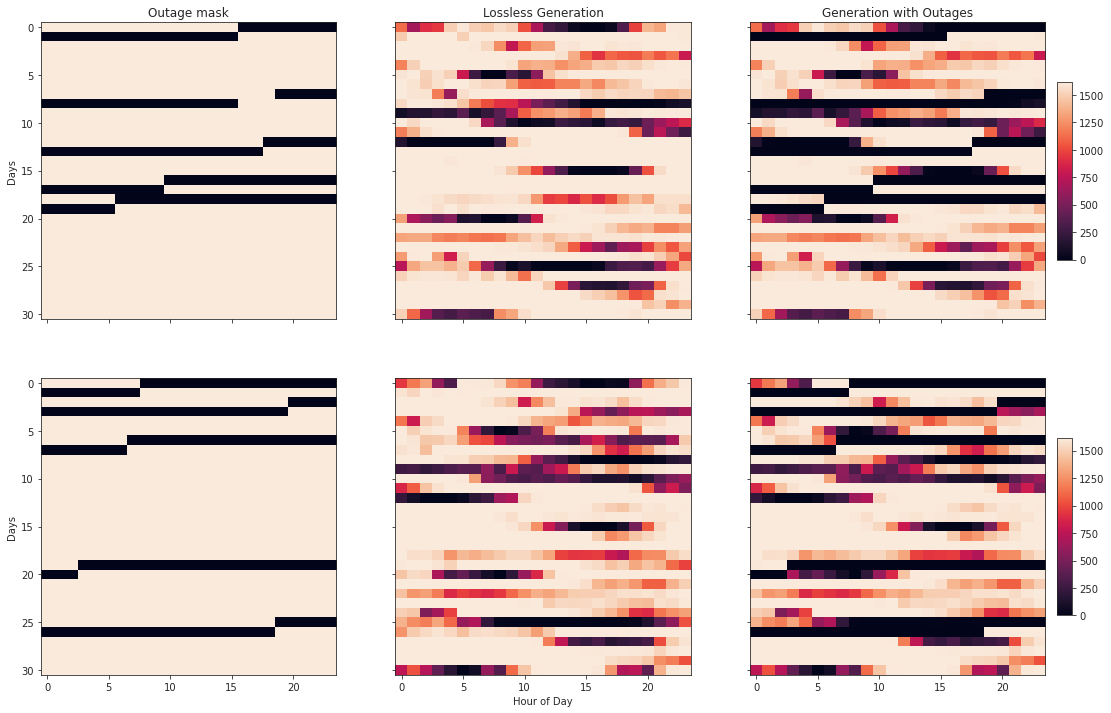

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
for site_ind in range(gen.out['gen_profile'].shape[1]):
    jan_gen_profile = gen.out['gen_profile'][:744, site_ind].reshape(-1, 24)
    jan_gen_profile_lossless = gen_lossless.out['gen_profile'][:744, site_ind].reshape(-1, 24)
    axes[site_ind, 0].imshow((jan_gen_profile_lossless - jan_gen_profile) <= 1e-3, aspect='auto')
    gen_vals = axes[site_ind, 1].imshow(jan_gen_profile_lossless, aspect='auto')
    axes[site_ind, 2].imshow(jan_gen_profile, aspect='auto')
    if site_ind == 0:
        axes[site_ind, 0].set_title("Outage mask")
        axes[site_ind, 1].set_title("Lossless Generation")
        axes[site_ind, 2].set_title("Generation with Outages")
    else:
        axes[site_ind, 1].set_xlabel("Hour of Day")
    axes[site_ind, 0].set_ylabel("Days")
    cax = axes[site_ind, 2].inset_axes([1.04, 0.2, 0.05, 0.6], transform=axes[site_ind, 2].transAxes)
    fig.colorbar(gen_vals, ax=axes[site_ind, 2], cax=cax)

<br>
Importantly, as long as the outage info and the location ID (or coordinates) remain the same, the stochastically scheduled outages remain reproducible! The cell below demonstrates this.

Second generation run matches first: True


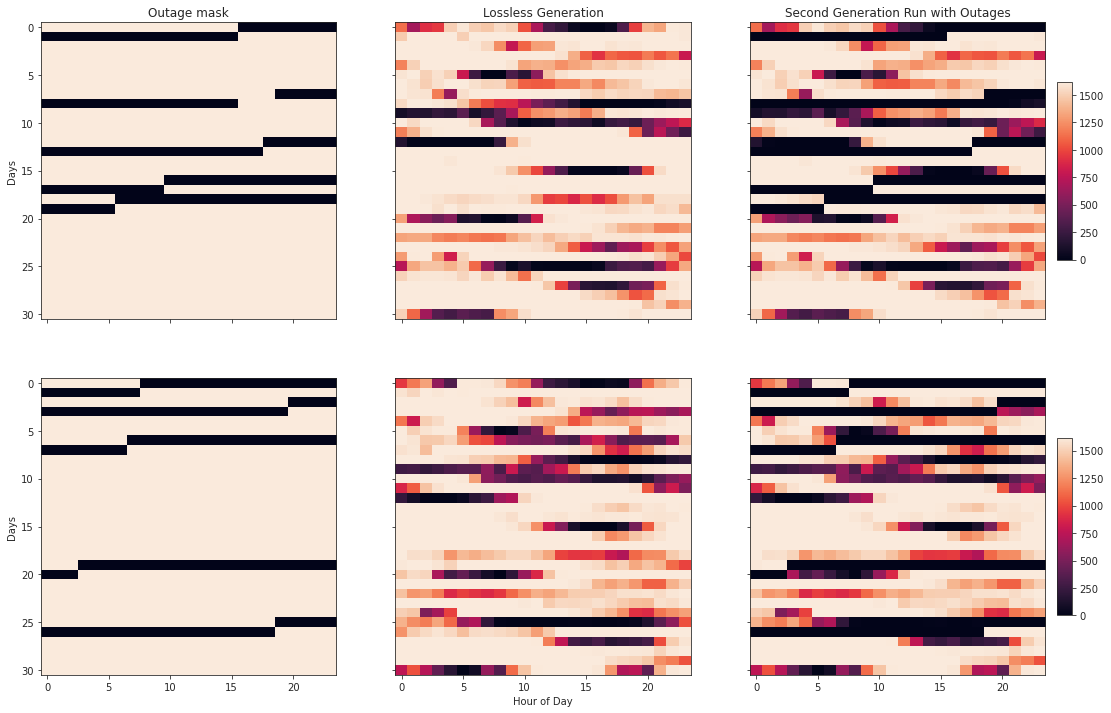

In [20]:
outage_info = [
    {
        'count': 5,
        'duration': 24,
        'percentage_of_farm_down': 100,
        'allowed_months': ['January'],
    }
]
with tempfile.TemporaryDirectory() as td:
    sam_fp = os.path.join(td, 'gen.json')
    sam_config['reV-outages'] = outage_info
    with open(sam_fp, 'w+') as fh:
        fh.write(json.dumps(sam_config))

    pp_2 = ProjectPoints.lat_lon_coords(lat_lons, res_file, sam_fp)
    gen_2 = Gen.reV_run('windpower', pp_2, sam_fp, res_file,
                        max_workers=1, out_fpath=None,
                        output_request=(
                            'cf_mean', 
                            'cf_profile', 
                            'gen_profile',
                        ))

print("Second generation run matches first:", np.isclose(gen.out['gen_profile'], gen_2.out['gen_profile']).all())

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
for site_ind in range(gen_2.out['gen_profile'].shape[1]):
    jan_gen_profile_2 = gen_2.out['gen_profile'][:744, site_ind].reshape(-1, 24)
    jan_gen_profile_lossless = gen_lossless.out['gen_profile'][:744, site_ind].reshape(-1, 24)
    axes[site_ind, 0].imshow((jan_gen_profile_lossless - jan_gen_profile_2) <= 1e-3, aspect='auto')
    gen_vals = axes[site_ind, 1].imshow(jan_gen_profile_lossless, aspect='auto')
    axes[site_ind, 2].imshow(jan_gen_profile_2, aspect='auto')
    if site_ind == 0:
        axes[site_ind, 0].set_title("Outage mask")
        axes[site_ind, 1].set_title("Lossless Generation")
        axes[site_ind, 2].set_title("Second Generation Run with Outages")
    else:
        axes[site_ind, 1].set_xlabel("Hour of Day")
    axes[site_ind, 0].set_ylabel("Days")
    cax = axes[site_ind, 2].inset_axes([1.04, 0.2, 0.05, 0.6], transform=axes[site_ind, 2].transAxes)
    fig.colorbar(gen_vals, ax=axes[site_ind, 2], cax=cax)

<br>
We can also specify multiple outages and allow them to overlap (or not):

In [21]:
outage_info = [
    {
        'count': 6,
        'duration': 24,
        'percentage_of_farm_down': 100,
        'allowed_months': ['January'],
        # We can allow overlap with other outages, but in practice this will 
        # not happen since we take down 100% of the farm at a time
        'allow_outage_overlap': True 
    },
    {
        'count': 15,
        'duration': 10,
        'percentage_of_farm_down': 40,
        'allowed_months': ['January'],
        # In this case, we allow overlap with the next outage
        'allow_outage_overlap': True
    },
    {
        'count': 20,
        'duration': 5,
        'percentage_of_farm_down': 40,
        'allowed_months': ['January'],
        # In this case, we allow overlap with the previous outage
        'allow_outage_overlap': True
    },
    {
        'count': 10,
        'duration': 1,
        'percentage_of_farm_down': 10,
        'allowed_months': ['January'],
        # Although the percentage of the farm that goes down is small, we can 
        # specify that we do not want this outage to overlap with any others. 
        'allow_outage_overlap': False
    },
]
with tempfile.TemporaryDirectory() as td:
    sam_fp = os.path.join(td, 'gen.json')
    sam_config['reV-outages'] = outage_info
    with open(sam_fp, 'w+') as fh:
        fh.write(json.dumps(sam_config))

    pp = ProjectPoints.lat_lon_coords(lat_lons, res_file, sam_fp)
    gen = Gen.reV_run('windpower', pp, sam_fp, res_file,
                      max_workers=1, out_fpath=None,
                      output_request=(
                          'cf_mean', 
                          'cf_profile', 
                          'gen_profile',
                          'windspeed'
                      ))
display(gen.out['cf_mean'])

array([0.58075225, 0.5646579 ], dtype=float32)

<br>
We can see that the additional outages resulted in larger losses in January, up to ~35%:

In [22]:
gen.out['cf_profile'][:744].mean(axis=0) / gen_lossless.out['cf_profile'][:744].mean(axis=0) * 100

array([65.6668 , 66.78839], dtype=float32)

<br>
The visualization of multiple outages is slightly more difficult to interpret, since outages can overlap and are not necessarily at 100% farm downtime. Still, it is illustrative to compare the lossless generation to the generation with outages:

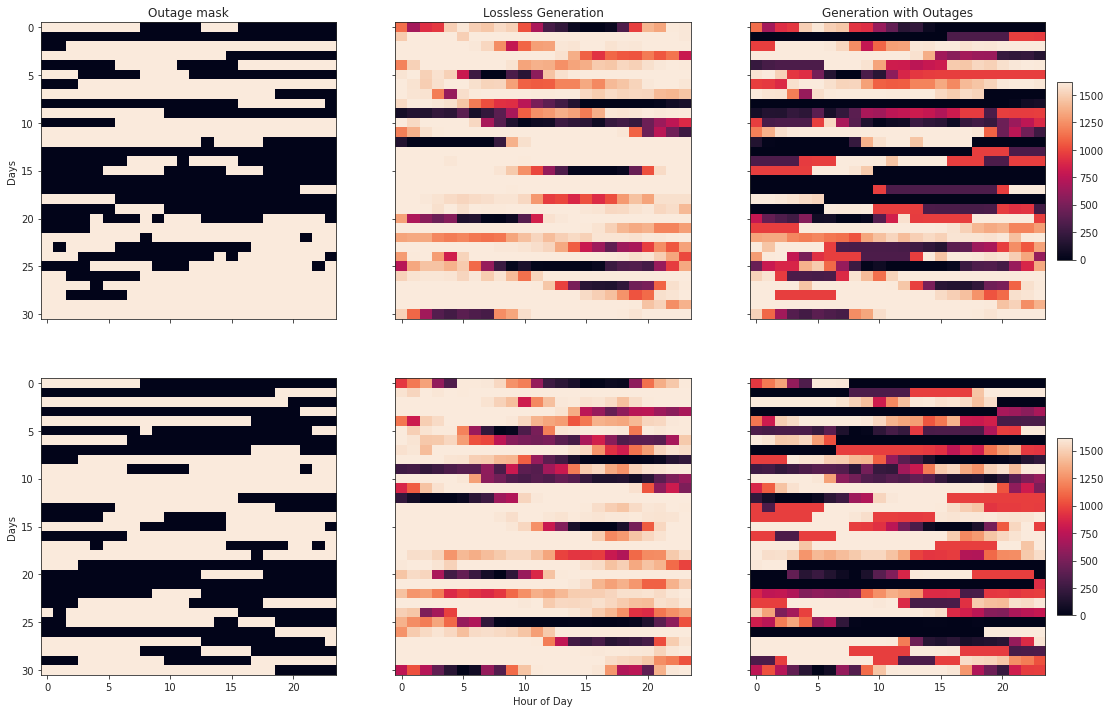

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
for site_ind in range(gen.out['gen_profile'].shape[1]):
    jan_gen_profile = gen.out['gen_profile'][:744, site_ind].reshape(-1, 24)
    jan_gen_profile_lossless = gen_lossless.out['gen_profile'][:744, site_ind].reshape(-1, 24)
    axes[site_ind, 0].imshow((jan_gen_profile_lossless - jan_gen_profile) <= 1e-3, aspect='auto')
    gen_vals = axes[site_ind, 1].imshow(jan_gen_profile_lossless, aspect='auto')
    axes[site_ind, 2].imshow(jan_gen_profile, aspect='auto')
    if site_ind == 0:
        axes[site_ind, 0].set_title("Outage mask")
        axes[site_ind, 1].set_title("Lossless Generation")
        axes[site_ind, 2].set_title("Generation with Outages")
    else:
        axes[site_ind, 1].set_xlabel("Hour of Day")
    axes[site_ind, 0].set_ylabel("Days")
    cax = axes[site_ind, 2].inset_axes([1.04, 0.2, 0.05, 0.6], transform=axes[site_ind, 2].transAxes)
    fig.colorbar(gen_vals, ax=axes[site_ind, 2], cax=cax)

Keep in mind that outage losses can be applied to solar generation runs as well.

On a final note, all of these losses can still be combined with haircut losses, if you wish, by setting the respective SAM loss keys (i.e. `turb_generic_loss`) to a non-zero value.